In [1]:
import numpy as np
import lightcones as lc
import lightcones.linalg as la
import matplotlib.pyplot as plt
from lightcones.linalg import mv
from lightcones import models
from lightcones.jumps import make_jump
from lightcones.solvers.schrodinger import solve
plt.rcParams['text.usetex'] = True

Let us construct the moving frame: 


In [2]:
# chain
n_sites = 100
# on-site energies
es = [1]*n_sites
# hoppings
hs = [0.05]*(n_sites-1)

# time grid
dt = 0.01
nt = 20000

# spread
spread = lc.spread(es, hs, nt, dt)

# rho_plus
rho_plus = lc.rho_plus(spread, dt)

# minimal light cone
rtol = 10**(-4)
ti_arrival, spread_min, U_min, rho_plus_min = lc.minimal_forward_frame(spread, rho_plus, dt, rtol)

# causal diamond frame
cd_dim = 4
spread_cd, U_cd = lc.causal_diamond_frame(spread_min, ti_arrival, U_min, rho_plus_min, dt, rtol, cd_dim)

# moving frame
spread_mv, H_mv = lc.moving_frame(spread_cd, ti_arrival, U_cd, dt, cd_dim)

Let us compute a single jump trajectory:

In [15]:

# Now solve the same problem in the moving frame

# Time step
dt = 0.01

# Final grid
t_max = 100
t = np.arange(0, t_max + dt, dt)
n_time = t.size

num_modes = lc.m_in(ti_arrival, n_time - 1)
max_num_quanta = 5
m = models.spin_boson(num_modes, max_num_quanta)

wq = 1.0
Hs = wq * m.s_p @ m.s_m
g = 0.05
V = g * m.s_m
V_dag = g * m.s_p

def f(ti):
    return(0.1*np.cos((ti + 0.5)*dt))

psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1

Ht = None
Hint = m.space.zero_op

m_out_prev = 0

def begin_step(ti, psi):
    m_out, m_in = lc.get_inout_range(ti_arrival, ti, cd_dim)
    
    # if the number of decoupled modes is changed: we need to make a jump
    global m_out_prev
    if m_out != m_out_prev:
       psi[:] = make_jump(psi, m.space, m_out_prev + 1) # + 1 because the first mode is the qubit
       m_out_prev = m_out 
    
    global Hint
    if m_in > 0:
        Hint = V_dag @ sum(spread_mv[m_out : m_in, ti] * m.a[m_out : m_in])
        Hint = Hint + Hint.conj().transpose()
    global Ht
    Ht = Hs + m.s_x * f(ti) + Hint
    Hw = m.zero_op
    W = lc.get_H(ti_arrival, H_mv, ti)
    if not W is None:
        for p in range(m_in - m_out):
            for q in range(m_in - m_out):
                Hw += 1j * m.a_dag[m_out + q] @ m.a[m_out + p] * W[q, p].conj()
    Ht = Ht + Hw
    
def apply_h(ti, psi_in, psi_out):
    mv(Ht, psi_in, psi_out)

# Here we store the average of observables
s_z_av_2 = []

def eval_o(ti, psi):
    s_z_av_2.append(np.vdot(psi, m.s_z @ psi))

solve(0, n_time-1, dt, apply_h, psi_0, begin_step = begin_step, eval_o = eval_o)

In the plot below we see discontinous changes in the qubit observables at the time moments of jumps:

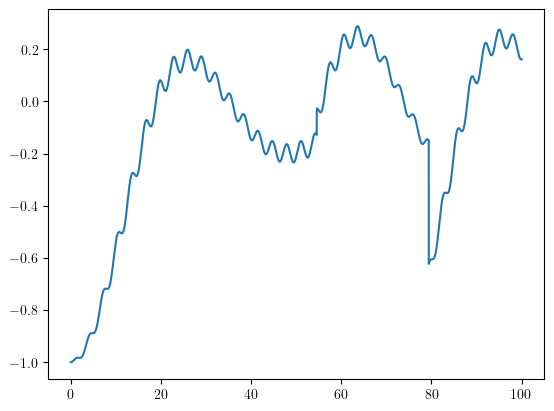

In [16]:
# plot the s_z average 
s_z_av_2 = np.array(s_z_av_2)
plt.plot(t, s_z_av_2.real)
# save picture to file
plt.savefig('s_z_av_spin_boson_model_jumpy.eps', format='eps')

In [ ]:
# Here we store the average of observables
s_z_av_3 = np.zeros(len(t))

In [25]:

# Now solve the same problem in the moving frame

n_trajectories = 100

# Time step
dt = 0.01

# Final grid
t_max = 100
t = np.arange(0, t_max + dt, dt)
n_time = t.size

num_modes = lc.m_in(ti_arrival, n_time - 1)
max_num_quanta = 5
m = models.spin_boson(num_modes, max_num_quanta)

wq = 1.0
Hs = wq * m.s_p @ m.s_m
g = 0.05
V = g * m.s_m
V_dag = g * m.s_p

def f(ti):
    return(0.1*np.cos((ti + 0.5)*dt))

psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1

Ht = None
Hint = m.space.zero_op

m_out_prev = 0

def begin_step(ti, psi):
    m_out, m_in = lc.get_inout_range(ti_arrival, ti, cd_dim)
    
    # if the number of decoupled modes is changed: we need to make a jump
    global m_out_prev
    if m_out != m_out_prev:
       psi[:] = make_jump(psi, m.space, m_out_prev + 1) # + 1 because the first mode is the qubit
       m_out_prev = m_out 
    
    global Hint
    if m_in > 0:
        Hint = V_dag @ sum(spread_mv[m_out : m_in, ti] * m.a[m_out : m_in])
        Hint = Hint + Hint.conj().transpose()
    global Ht
    Ht = Hs + m.s_x * f(ti) + Hint
    Hw = m.zero_op
    W = lc.get_H(ti_arrival, H_mv, ti)
    if not W is None:
        for p in range(m_in - m_out):
            for q in range(m_in - m_out):
                Hw += 1j * m.a_dag[m_out + q] @ m.a[m_out + p] * W[q, p].conj()
    Ht = Ht + Hw
    
def apply_h(ti, psi_in, psi_out):
    mv(Ht, psi_in, psi_out)

def eval_o(ti, psi):
    s_z_av_3[ti] = s_z_av_3[ti] + np.vdot(psi, m.s_z @ psi)

for i in range(n_trajectories):
    m_out_prev = 0
    solve(0, n_time-1, dt, apply_h, psi_0, begin_step = begin_step, eval_o = eval_o)

/tmp/ipykernel_470144/33932662.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  s_z_av_3[ti] = s_z_av_3[ti] + np.vdot(psi, m.s_z @ psi)


However the average over many jump trajectories becomes smooth and reproduces the exact quantum dynamics:

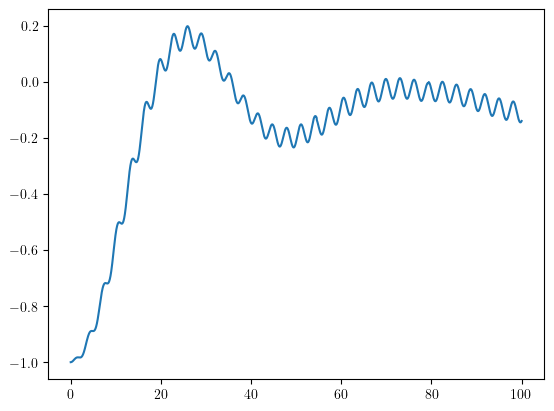

In [26]:
# plot the s_z average 
plt.plot(t, s_z_av_3.real / 100)
# save picture to file
plt.savefig('s_z_av_spin_boson_model_jump_average.eps', format='eps')

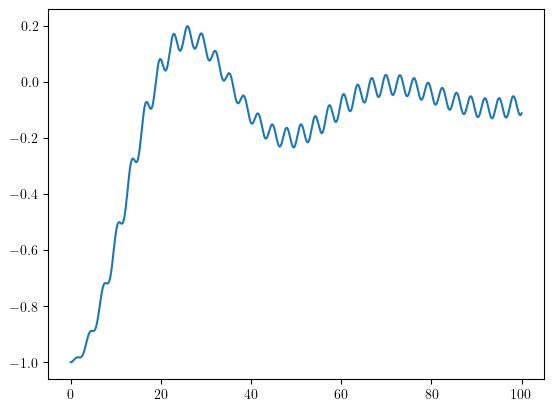

In [20]:
# Let us solve the spin boson model the original (chain sites) picture
# define the Hamiltonian of the spin-boson model

# number of boson chain modes
num_chain_modes = 15

# keep in the truncated Fock space only states in which 
# the bosonic chain has no more than max_num_quanta quanta
max_num_quanta = 5

# sparse matrices for the model
m = models.spin_boson(num_chain_modes, max_num_quanta)

# Hamitonian for the spin (qubit)
# Rabi (level splitting)
Omega = 2.0
Hs = m.s_p @ m.s_m * Omega / 2

# Coupling to the chain via raising / lowering Pauli matrices
# coupling strength g
g = 0.05
V = g * m.s_m @ m.a_dag[0]
V_dag = V.T.conj()

# Free bosonic chain Hamiltonian (on-site energy e and hopping h)
e = 1.0
h = 0.05
Hb = e * sum([m.a_dag[i] @ m.a[i] for i in range(num_chain_modes)]) \
    + h * sum([m.a_dag[i + 1] @ m.a[i] + m.a_dag[i] @ m.a[i + 1] for i in range(num_chain_modes - 1)])
    
# joint Hamiltonian
Hsb = Hs + V + V_dag + Hb

# The qubit is periodically driven
def drive(t):
    return(0.1*np.cos(t)) * m.s_x

# The Hamiltonian for the driven spin-boson model
def Hsb_driven(t):
    return Hsb + drive(t)

# The non-stationary Schrodinger equation is solved on a time grid
# [0    dt    2*dt    ...    k*dt  ... ]
# The time grid points are numbered by integer ti
# [0    1     2       ....   k     ... ]
# The time-dependent Hamiltonian is invoked by the solver with ti argument,
# and the corresponding time moment is (ti + 0.5)*dt
# Here 0.5*dt is due to the midpoint integration rule

# Time step
dt = 0.01

# Final grid
t_max = 100
t = np.arange(0, t_max + dt, dt)
n_time = t.size

# Callback function which applies Hamiltonian to the wavefunction at each time grid point ti
def apply_h(ti, psi_in, psi_out):
    H = Hsb_driven((ti + 0.5) * dt)
    mv(H, psi_in, psi_out, cout=1)

# Here we store the average of observables
s_z_av = []

# Callback function which evaluates observables at each time grid point ti
def eval_o(ti, psi):
    s_z_av.append(np.vdot(psi, m.s_z @ psi))
    
# initial condition:
# vacuum state for bosonic chain,
# and ground state for spin (qubit)
psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1.0 
    
# Solve the non-stationary Schrodinger equation
solve(0, n_time-1, dt, apply_h, psi_0, eval_o = eval_o)

# plot the s_z average 
s_z_av = np.array(s_z_av)
plt.plot(t, s_z_av.real)
# save picture to file
plt.savefig('s_z_av_spin_boson_model.eps', format='eps')

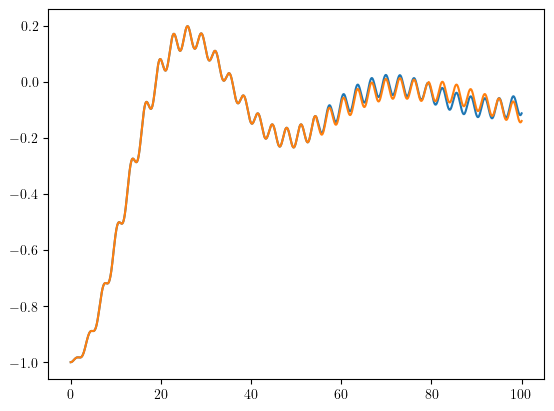

In [27]:
# Compare with the average over the quantum jump trajectories

# plot the s_z average 
plt.plot(t, s_z_av.real)
plt.plot(t, s_z_av_3.real / 100)
# save picture to file
plt.savefig('s_z_av_spin_boson_model_jump_average_compared.eps', format='eps')